In [2]:
import json
import codecs
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, plot_roc_curve
import glob
from os import path
from statistics import mean
import pandas as pd
from matplotlib import pyplot as plt
pd.set_option("display.precision", 4)

## Parameters

In [3]:
results_path = 'results'
best_results_filename = 'best_results.txt'


In [4]:
all_files = glob.glob(f'{results_path}/*/{best_results_filename}')

## Collecting results

In [5]:
def no_plot_calculate_metrics(best_model_results, mode = 'dev'):
    preds = np.array(best_model_results[mode]['preds']).argmax(axis = 1)
    pred_raw = best_model_results[mode]['preds']
    targets = np.array(best_model_results[mode]['solutions']).argmax(axis = 1)
    df = pd.DataFrame({'preds':preds, 'pred_raw':pred_raw, 'targets': targets})

    rep3 = pd.DataFrame(classification_report(y_true=targets, y_pred=preds, output_dict=True)).transpose()
    precision3,recall3,fscore3,support3 = precision_recall_fscore_support(y_true = targets, y_pred = preds, average='macro')
    cm3 = confusion_matrix(targets, preds)
    
    df = df[~(df.targets == 1)].copy()
    targets = df.targets.map({0:0, 2:1})
    preds = pd.DataFrame(df.pred_raw.values.tolist()).drop(columns=[1]).values.argmax(axis = 1)
    pred_raw = pd.DataFrame(df.pred_raw.values.tolist()).drop(columns=[1]).values


    rep2 = pd.DataFrame(classification_report(y_true=targets, y_pred=preds, output_dict=True)).transpose()
    precision2,recall2,fscore2,support2 = precision_recall_fscore_support(y_true = targets, y_pred = preds, average='macro')
    cm2 = confusion_matrix(targets, preds)

    return rep2, precision2, recall2, fscore2, support2, cm2, rep3, precision3, recall3, fscore3, support3, cm3

In [24]:
all_dev_acc_2 = []
all_dev_acc_3 = []
all_dev_f1_2 = []
all_dev_f1_3 = []
best_dev_f1_2 = -1
best_dev_f1_3 = -1

best_dev_acc_2 = -1
best_model2 = dict()
best_dev_acc_3 = -1
best_model3 = dict()
count = 1
best_count = 1

rep2_accumulated = None
rep3_accumulated = None

for filepath in all_files:
    # print(f'File {count}')
    with codecs.open(filepath, "r",  'utf-8-sig') as read_file:
        atae_data = json.load(read_file)
        # print(atae_data.keys())
        t = atae_data['acc_train'] 
        d = atae_data['acc_dev']

        rep2, precision2, recall2, fscore2, support2, cm2, rep3, precision3, recall3, fscore3, support3, cm3 = no_plot_calculate_metrics(atae_data)

        if fscore2 > best_dev_f1_2:
            best_dev_f1_2 = fscore2
            best_f1_model2 = atae_data
        
        if fscore3 > best_dev_f1_3:
            best_f1_model3 = atae_data
            best_dev_f1_3 = fscore3

        all_dev_f1_2.append(fscore2)
        all_dev_f1_3.append(fscore3)

        all_dev_acc_2.append(d['binary'])
        all_dev_acc_3.append(d['three-way'])
        
        if d['binary'] > best_dev_acc_2:
            best_dev_acc_2 = d["binary"]
            best_model2 = atae_data
        
        if d['three-way'] > best_dev_acc_3:
            best_model3 = atae_data
            best_dev_acc_3 = d['three-way']
            best_count = count
        
        test = atae_data['acc_test']
        preds = np.array(atae_data['test']['preds']).argmax(axis = 1)
        targets = np.array(atae_data['test']['solutions']).argmax(axis = 1)
        df = pd.DataFrame({'preds':preds, 'targets':targets})
        count = count + 1


print(f'mean dev acc binary {mean(all_dev_acc_2)}')
print(f'mean dev acc three-way {mean(all_dev_acc_3)}')
print(f'best acc binary -> {max(all_dev_acc_2)}  best acc three-way -> {max(all_dev_acc_3)}')
print(f'mean dev f1 binary {mean(all_dev_f1_2)}')
print(f'mean dev f1 three-way {mean(all_dev_f1_3)}')
print(f'best f1 binary -> {best_dev_f1_2} best f1 three-way -> {best_dev_f1_3}')


mean dev acc binary 0.8840039658216239
mean dev acc three-way 0.8269037652212926
best acc binary -> 0.9296482412060302  best acc three-way -> 0.8851674641148325 
mean dev f1 binary 0.6046322721894777
mean dev f1 three-way 0.3901375906448829
best f1 binary -> 0.6990285475892484 best f1 three-way -> 0.44402663533098313


In [25]:
def calculate_metrics(best_model_results, fig_file_name, roc_title, cm_file_name, cm_title, binary = False, mode = 'test'):
    # print(best_model_results['test']['aspect'])
    preds = np.array(best_model_results[mode]['preds']).argmax(axis = 1)
    pred_raw = best_model_results[mode]['preds']
    targets = np.array(best_model_results[mode]['solutions']).argmax(axis = 1)
    df = pd.DataFrame({'preds':preds, 'pred_raw':pred_raw, 'targets': targets})
    # print(df.preds.value_counts(), df.targets.value_counts())

    if binary:
        df = df[~(df.targets == 1)].copy()
        preds = df.preds.map({0:0, 2:1})
        targets = df.targets.map({0:0, 2:1})
        pred_raw = pd.DataFrame(df.pred_raw.values.tolist()).drop(columns=[1]).values

    rep = pd.DataFrame(classification_report(y_true=targets, y_pred=preds, output_dict=True)).transpose()
    precision,recall,fscore,support = precision_recall_fscore_support(y_true = targets, y_pred = preds)
    cm = confusion_matrix(targets, preds)
    
    import scikitplot as skplt
    skplt.metrics.plot_roc(y_true = targets, y_probas = pred_raw, title = 'ROC: ' + roc_title)
    plt.savefig(f'{mode}_{fig_file_name}', dpi = 300)

    # print(preds)
    skplt.metrics.plot_confusion_matrix(
        y_true = targets,
        y_pred = preds,
        normalize=False,
        title=cm_title,
        figsize=(10, 8),
    )
    plt.savefig(f'{mode}_{cm_file_name}', dpi = 300)

    return rep, precision, recall, fscore, support, cm

## Test Acc for Best BINARY Model

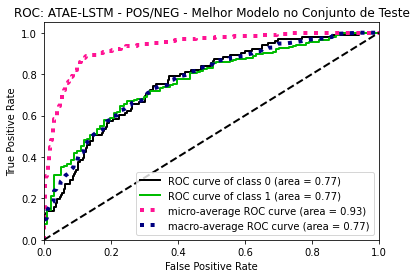

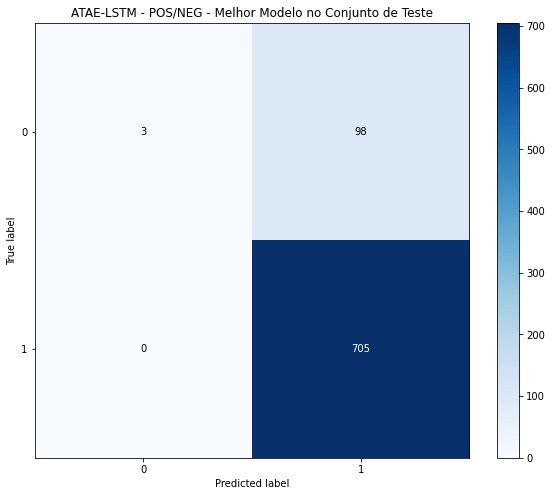

In [26]:
rep, precision, recall, fscore, support, cm = calculate_metrics(best_model2, 
                                                fig_file_name = 'ATAE_LSTM_best_binary_model_roc.pdf', 
                                                roc_title = 'ATAE-LSTM - POS/NEG - Melhor Modelo no Conjunto de Teste',
                                                cm_file_name = 'ATAE_LSTM_best_binary_model_cm.pdf',
                                                cm_title = 'ATAE-LSTM - POS/NEG - Melhor Modelo no Conjunto de Teste',
                                                binary = True,
                                                mode = 'test')

In [27]:
rep

,precision,recall,f1-score,support
0,1.0000,0.0297,0.0577,101.0000
1,0.8780,1.0000,0.9350,705.0000
accuracy,0.8784,0.8784,0.8784,0.8784
macro avg,0.9390,0.5149,0.4964,806.0000
weighted avg,0.8933,0.8784,0.8251,806.0000


## Test Acc for Best THREE-WAY Model

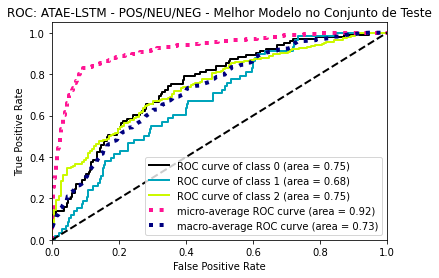

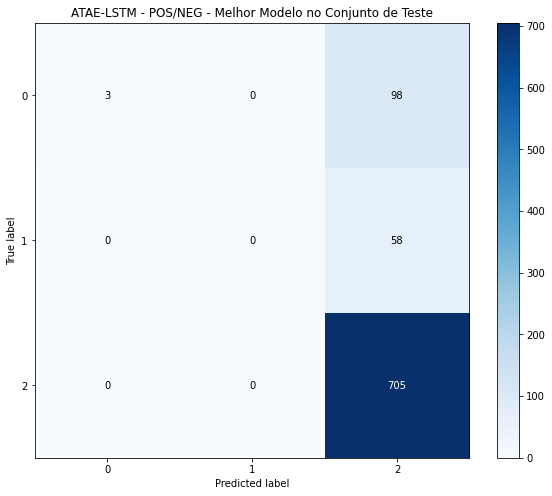

In [28]:
rep3, precision3, recall3, fscore3, support3, cm3 = calculate_metrics(best_model3,
                                                fig_file_name = 'ATAE_LSTM_best_threeway_model_roc.pdf', 
                                                roc_title = 'ATAE-LSTM - POS/NEU/NEG - Melhor Modelo no Conjunto de Teste',
                                                cm_file_name = 'ATAE_LSTM_best_threeway_model_cm.pdf',
                                                cm_title = 'ATAE-LSTM - POS/NEG - Melhor Modelo no Conjunto de Teste', mode = 'test')

In [29]:
rep3

,precision,recall,f1-score,support
0,1.0000,0.0297,0.0577,101.0000
1,0.0000,0.0000,0.0000,58.0000
2,0.8188,1.0000,0.9004,705.0000
accuracy,0.8194,0.8194,0.8194,0.8194
macro avg,0.6063,0.3432,0.3194,864.0000
weighted avg,0.7850,0.8194,0.7414,864.0000


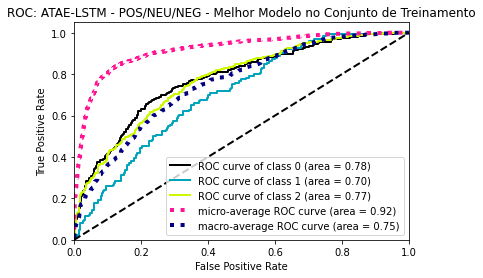

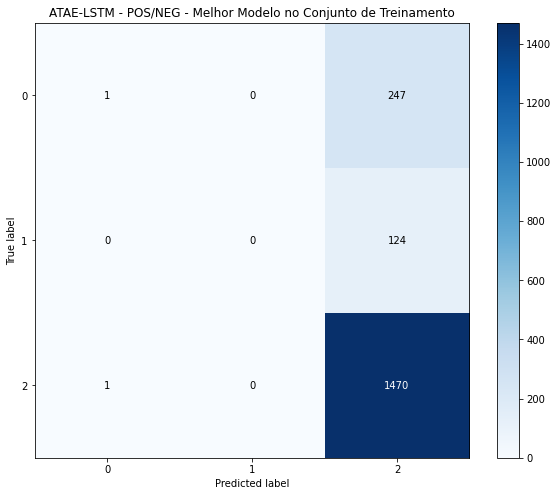

In [30]:
rep3, precision3, recall3, fscore3, support3, cm3 = calculate_metrics(best_model3,
                                                fig_file_name = 'ATAE_LSTM_best_threeway_model_roc.pdf', 
                                                roc_title = 'ATAE-LSTM - POS/NEU/NEG - Melhor Modelo no Conjunto de Treinamento',
                                                cm_file_name = 'ATAE_LSTM_best_threeway_model_cm.pdf',
                                                cm_title = 'ATAE-LSTM - POS/NEG - Melhor Modelo no Conjunto de Treinamento', mode = 'train')

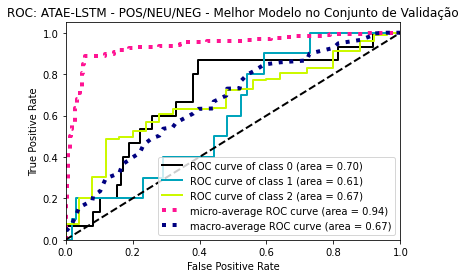

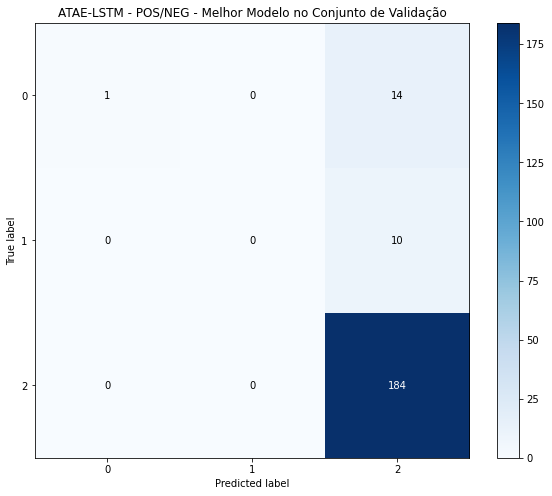

In [31]:
rep3, precision3, recall3, fscore3, support3, cm3 = calculate_metrics(best_model3,
                                                fig_file_name = 'ATAE_LSTM_best_threeway_model_roc.pdf', 
                                                roc_title = 'ATAE-LSTM - POS/NEU/NEG - Melhor Modelo no Conjunto de Validação',
                                                cm_file_name = 'ATAE_LSTM_best_threeway_model_cm.pdf',
                                                cm_title = 'ATAE-LSTM - POS/NEG - Melhor Modelo no Conjunto de Validação', mode = 'dev')

# Saving data for Ensemble